# Parzen - Window Density Estimation

This notebook shows how you can estimate the distribution of the data to be used for analysis or a model like Bayes Classifier which is what we are doing.

**Explanation**

What this does is that for each class each row is treated as a probability distribution and then we consider the probability distribution of the class as the *sum of all probability distributions of the rows*.

$P(\tilde{X}) = \frac{1}{M} \sum_{m=1}^M \phi_h(X-X_m)$

where $\phi_h = \frac{1}{h}g(\frac{X}{h})$ and g is any valid probability density function

Reminder of Bayes Rule : $P(C_k|x) = \frac{P(x|C_k) * P(C_k)}{P(X)}$

What we are trying to de here is trying to estimate $P(x|C_k)$ for each class which allows us to use it in Bayes Theorem as estimating P(C_k) is relatively easy.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Reading The Data

In [2]:
def read_test_data():

    test_data = pd.read_csv('test_data.csv',names=['Feature1'])
    test_data_true = pd.read_csv('test_data_true.csv',names=['Class'])

    return test_data, test_data_true

def read_data():
    
    data = pd.read_csv('data.csv',names=['Class','Feature1'])
    return data

In [3]:
data = read_data()
data_X = np.asarray(data.drop(['Class'],axis=1).copy())
data_y = np.asarray(data['Class'].copy())
test_data, test_data_true = read_test_data()
test_data , test_data_true= test_data.values , test_data_true.values
 

According to Bowman, A.W., and Azzalini, A. (1997), Applied Smoothing Techniques for Data Analysis, London: Oxford University Press [page 32].

The optimal value of h can be obtained through.

$h_opt = \frac{1}{N}\sum_{i=1}^NH_i\\
H_i = \sigma_i [\frac{4}{(N+2)M}]^{\frac{1}{N+4}}\\\sigma_i = \sqrt{\Sigma_{X_{ii}}}$



In [4]:
def calculate_h_optimal(X_Class):
    #.

    h = 0
    M = X_Class.shape[0]
    N = X_Class.shape[1]
    sigma_diagonal  = np.multiply(np.cov(X_Class,rowvar=False) , np.eye(N))

    Const = np.power(  4 /( (N+2)*M ) , 1/(N+4) )
    
    h = np.sum( np.sqrt(sigma_diagonal) * Const )
    
    
    return h

For our choice of $g(x)$ , we chose a bounded gaussian distribution.

Which is just like a gaussian distribution but doesnt range from $-\infty < x < \infty$ instead $- k\,\sigma < x < k\,\sigma$ where sigma is the standard deviation and k is a hyperparameter

In [5]:
def gaussian_bump(x,h,sigma=0.85):
    
    return np.exp(-x**2/(2*(sigma*h)**2))/(np.sqrt(2*np.pi)*h*sigma)/ x.shape[0] / h

def bounded_gaussian_bump(x,h,points,sigma,bound):
    '''
    Bound here refers to :
    That X will be in range of  point - sigma * bound < x < point + sigma*bound
    So bound is in term of sigma not absolute
    '''
    Mask1 = x > (points - sigma*bound)[:,None]
    Mask2 = x < (points + sigma*bound)[:,None]

    FullMask = Mask1 * Mask2
    FullMask = np.squeeze(FullMask,axis=1)

    return gaussian_bump(x-points,h,sigma) * FullMask 

In [7]:
# Separating the two classes
C1 = data_X[data_y == 1]
C2 = data_X[data_y == 2]

In [8]:
# Adding X-axis for plotting
min_x = min(np.min(C1) , np.min(C2))
max_x = max(np.max(C1) , np.max(C2))
number_of_axis_points = 10000
x = np.linspace(min_x,max_x,number_of_axis_points)

In [9]:
# Calculating optimal h for each class
h1 = calculate_h_optimal(C1)
h2 = calculate_h_optimal(C2)

In [10]:
# calculating P(X|C_k) to use in Bayes Rule
pxgivenC1 = np.sum(bounded_gaussian_bump(x=x,h=h1,points=C1,sigma=1,bound=3),axis=0) 

pxgivenC2 = np.sum(bounded_gaussian_bump(x=x,h=h2,points=C2,sigma=0.9,bound=np.inf) ,axis=0)

Plotting the data vs real data

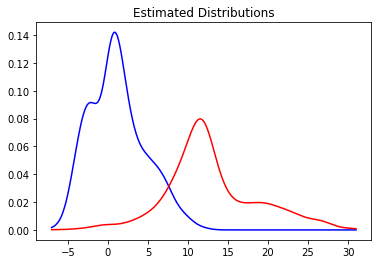

In [13]:
plt.plot(x,pxgivenC1,'b-')
plt.plot(x,pxgivenC2,'r-')
plt.title('Estimated Distributions');

Real Distributions

![True pdfs](./TrueDistributions.png "Real Distributions") 

Now that we have estimated $P(x|C_k)$ , we only need to calculate $P(C_k)$ to start using Bayes Rule

In [14]:
M = data_y.shape[0]
#Calculating the apriori probabilities p(C1) and p(C2).
pc1 = C1.shape[0] /M
pc2 = C2.shape[0] / M

In [17]:
pc1GivenX = pc1 * pxgivenC1
pc2GivenX = pc2 * pxgivenC2

In [15]:
def find_nearest(array, value):
 
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return index

Prediction Stage

In [18]:
accuracy = 0
predicted_class = []
for idx, point in enumerate(test_data):
    classification = np.argmax(np.array([pc1GivenX[find_nearest(x,point)],pc2GivenX[find_nearest(x,point)]])) + 1
    print("for point:", point, "the classification: ", classification)
    predicted_class.append(classification)

predicted_class = np.asarray(predicted_class)

accuracy = np.sum(np.reshape(predicted_class,(-1,1)) == np.reshape(test_data_true,(-1,1)))/test_data_true.shape[0] * 100


for point: [11.23317053] the classification:  2
for point: [17.05956066] the classification:  2
for point: [20.] the classification:  2
for point: [-3.1319357] the classification:  1
for point: [8.80189039] the classification:  2
for point: [6.] the classification:  1
for point: [0.14068925] the classification:  1
for point: [3.00817328] the classification:  1
for point: [5.] the classification:  1
for point: [1.45768636] the classification:  1
for point: [23.] the classification:  2
for point: [2.47872809] the classification:  1
for point: [-2.89862058] the classification:  1
for point: [2.88643351] the classification:  1
for point: [10.98552329] the classification:  2
for point: [10.50195166] the classification:  2
for point: [21.09271188] the classification:  2
for point: [0.75791643] the classification:  1
for point: [-4.01268405] the classification:  1
for point: [-2.83807276] the classification:  1
for point: [13.21236831] the classification:  2
for point: [18.] the classificatio

In [20]:
print("Accuracy = ", round(accuracy,2), "%")

Accuracy =  92.33 %
